# 👾 PixelCNN

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset.

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from utils.image import display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
RESIDUAL_BLOCKS = 5
EPOCHS = 2000

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs_int):
    imgs_int = np.pad(imgs_int , ((0,0), (2,2), (2,2)), constant_values= 0)
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs = imgs_int.astype("float32")
    imgs = imgs / 255.0
    
    return imgs, imgs_int

x_train, y_train = preprocess(x_train)

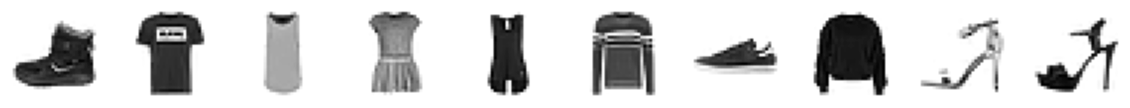

In [6]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the PixelCNN <a name="build"></a>

In [7]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(keras.layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = keras.layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [9]:
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = PixelConvLayer(mask_type="A"
                   , filters=256
                   , kernel_size=7
                   , activation="relu"
                   , padding="same")(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=256)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=256,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=256, kernel_size=1, strides=1, activation="softmax", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 32, 32, 256)      12800     
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 32, 32, 256)      393856    
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 32, 32, 256)      393856    
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 32, 32, 256)      393856    
 lock)                                                       

## 3. Train the PixelCNN <a name="train"></a>

In [10]:
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [11]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img
        
    def sample_from(self, probs, temperature): #<2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)
        
    def generate(self, temperature):
        generated_images = np.zeros(shape=(self.num_img,) + (pixel_cnn.input_shape)[1:])
        batch, rows, cols, channels = generated_images.shape
        
        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images)[:, row, col, :]
                    generated_images[:, row, col, channel] = [self.sample_from(x, temperature) for x in probs]
                    generated_images[:, row, col, channel] /= 255.0
                    
        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature = 1.0)
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        


Epoch 1/2000
469/469 [==============================] - ETA: 0s - loss: 2.0353INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_000.png


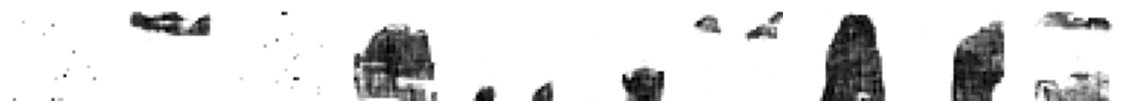

469/469 [==============================] - 250s 523ms/step - loss: 2.0353
Epoch 2/2000
469/469 [==============================] - ETA: 0s - loss: 1.7179INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_001.png


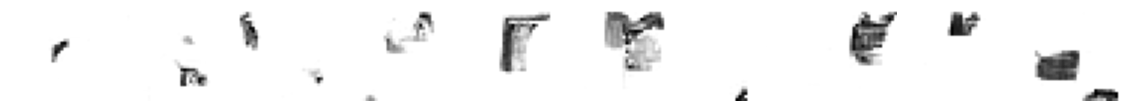

469/469 [==============================] - 244s 521ms/step - loss: 1.7179
Epoch 3/2000
469/469 [==============================] - ETA: 0s - loss: 1.6436INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_002.png


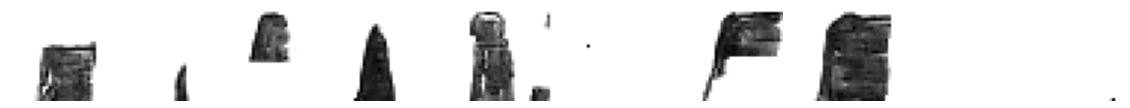

469/469 [==============================] - 244s 521ms/step - loss: 1.6436
Epoch 4/2000
469/469 [==============================] - ETA: 0s - loss: 1.6091INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_003.png


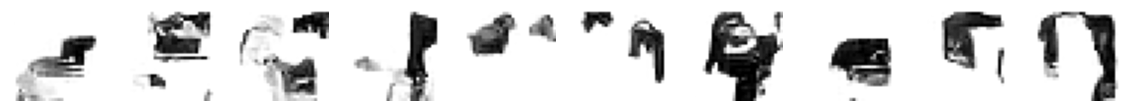

469/469 [==============================] - 245s 524ms/step - loss: 1.6091
Epoch 5/2000
469/469 [==============================] - ETA: 0s - loss: 1.5896INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_004.png


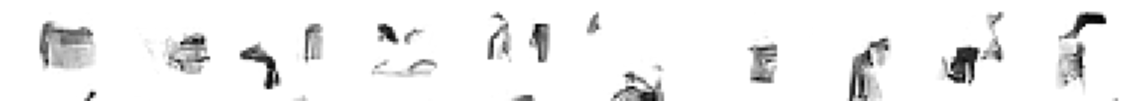

469/469 [==============================] - 243s 519ms/step - loss: 1.5896
Epoch 6/2000
469/469 [==============================] - ETA: 0s - loss: 1.5762INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_005.png


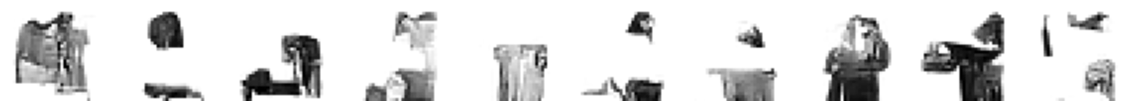

469/469 [==============================] - 243s 519ms/step - loss: 1.5762
Epoch 7/2000
469/469 [==============================] - ETA: 0s - loss: 1.5668INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_006.png


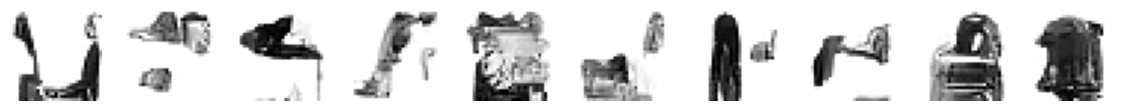

469/469 [==============================] - 244s 521ms/step - loss: 1.5668
Epoch 8/2000
469/469 [==============================] - ETA: 0s - loss: 1.5573INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_007.png


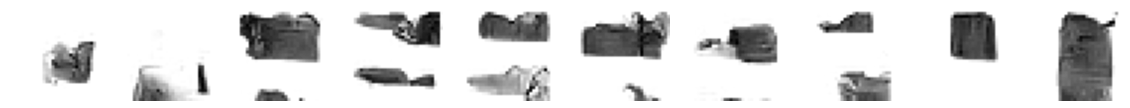

469/469 [==============================] - 244s 521ms/step - loss: 1.5573
Epoch 9/2000
469/469 [==============================] - ETA: 0s - loss: 1.5519INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_008.png


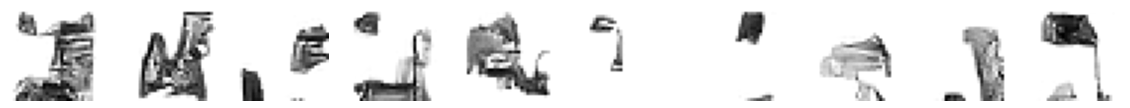

469/469 [==============================] - 243s 519ms/step - loss: 1.5519
Epoch 10/2000
469/469 [==============================] - ETA: 0s - loss: 1.5485INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_009.png


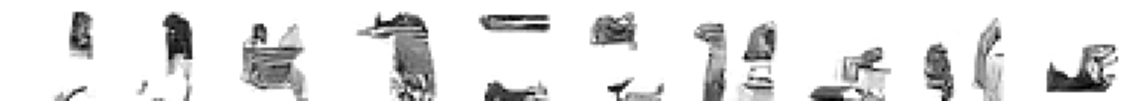

469/469 [==============================] - 243s 519ms/step - loss: 1.5485
Epoch 11/2000
469/469 [==============================] - ETA: 0s - loss: 1.5404INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_010.png


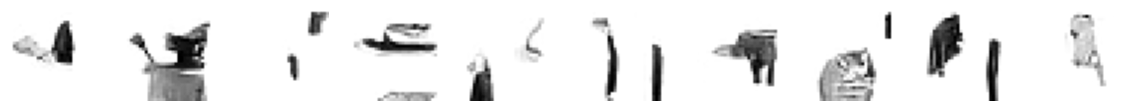

469/469 [==============================] - 244s 520ms/step - loss: 1.5404
Epoch 12/2000
469/469 [==============================] - ETA: 0s - loss: 1.5380INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_011.png


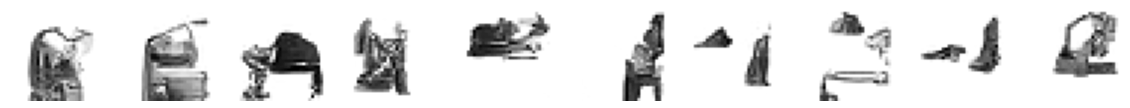

469/469 [==============================] - 246s 525ms/step - loss: 1.5380
Epoch 13/2000
469/469 [==============================] - ETA: 0s - loss: 1.5348INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_012.png


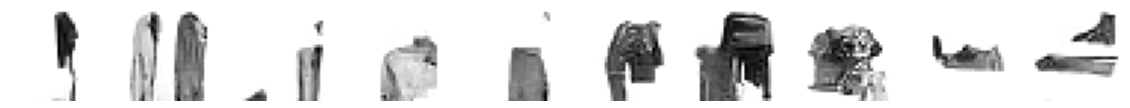

469/469 [==============================] - 250s 533ms/step - loss: 1.5348
Epoch 14/2000
469/469 [==============================] - ETA: 0s - loss: 1.5296INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_013.png


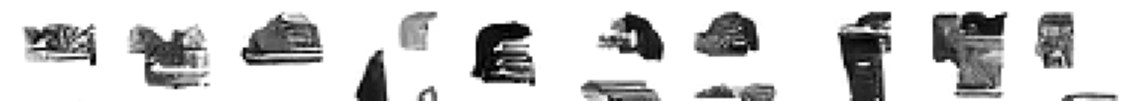

469/469 [==============================] - 248s 528ms/step - loss: 1.5296
Epoch 15/2000
469/469 [==============================] - ETA: 0s - loss: 1.5266INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_014.png


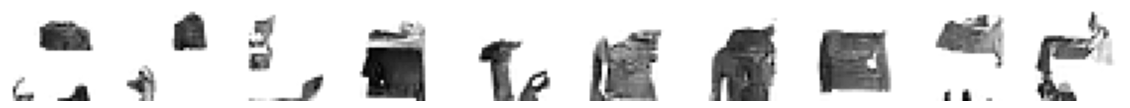

469/469 [==============================] - 245s 522ms/step - loss: 1.5266
Epoch 16/2000
469/469 [==============================] - ETA: 0s - loss: 1.5247INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_015.png


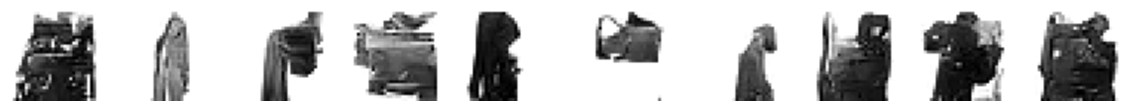

469/469 [==============================] - 244s 521ms/step - loss: 1.5247
Epoch 17/2000
469/469 [==============================] - ETA: 0s - loss: 1.5219INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_016.png


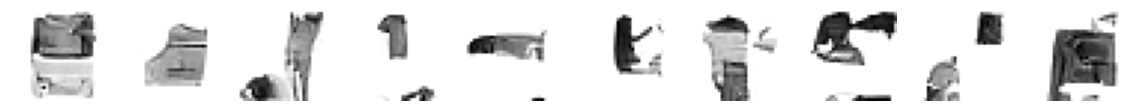

469/469 [==============================] - 243s 519ms/step - loss: 1.5219
Epoch 18/2000
469/469 [==============================] - ETA: 0s - loss: 1.5198INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_017.png


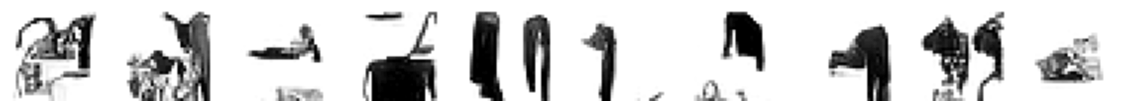

469/469 [==============================] - 243s 519ms/step - loss: 1.5198
Epoch 19/2000
469/469 [==============================] - ETA: 0s - loss: 1.5180INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_018.png


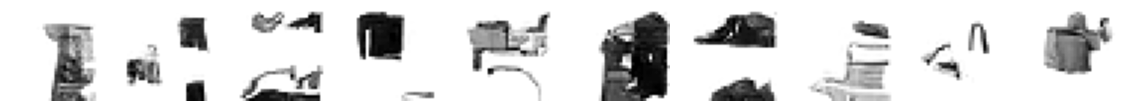

469/469 [==============================] - 243s 519ms/step - loss: 1.5180
Epoch 20/2000
469/469 [==============================] - ETA: 0s - loss: 1.5138INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_019.png


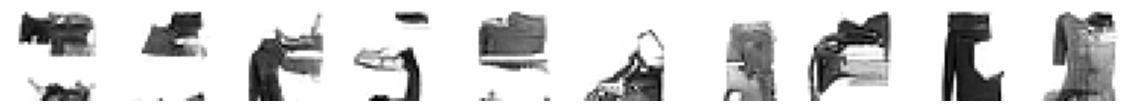

469/469 [==============================] - 244s 521ms/step - loss: 1.5138
Epoch 21/2000
469/469 [==============================] - ETA: 0s - loss: 1.5149
Saved to ./output/generated_img_020.png


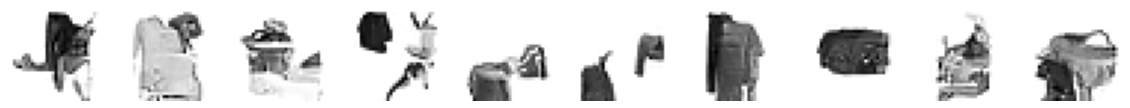

469/469 [==============================] - 241s 515ms/step - loss: 1.5149
Epoch 22/2000
469/469 [==============================] - ETA: 0s - loss: 1.5121INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_021.png


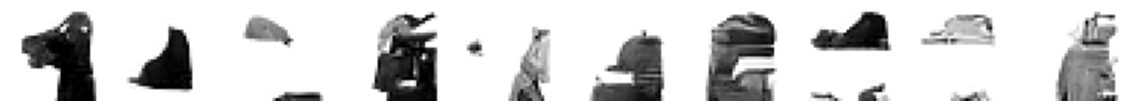

469/469 [==============================] - 243s 518ms/step - loss: 1.5121
Epoch 23/2000
469/469 [==============================] - ETA: 0s - loss: 1.5091INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_022.png


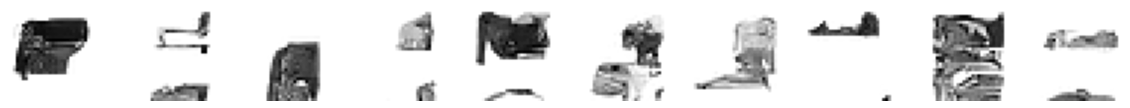

469/469 [==============================] - 243s 519ms/step - loss: 1.5091
Epoch 24/2000
469/469 [==============================] - ETA: 0s - loss: 1.5078INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_023.png


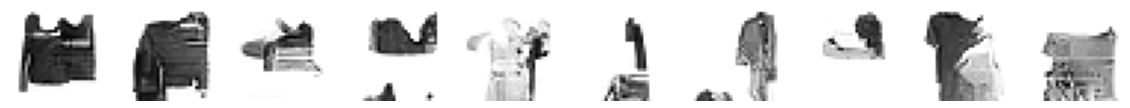

469/469 [==============================] - 243s 519ms/step - loss: 1.5078
Epoch 25/2000
469/469 [==============================] - ETA: 0s - loss: 1.5063INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_024.png


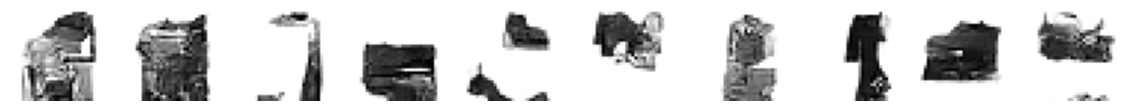

469/469 [==============================] - 243s 519ms/step - loss: 1.5063
Epoch 26/2000
469/469 [==============================] - ETA: 0s - loss: 1.5053INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_025.png


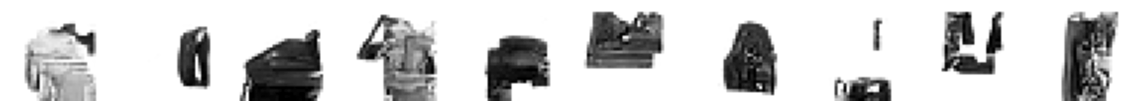

469/469 [==============================] - 243s 518ms/step - loss: 1.5053
Epoch 27/2000
469/469 [==============================] - ETA: 0s - loss: 1.5033INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_026.png


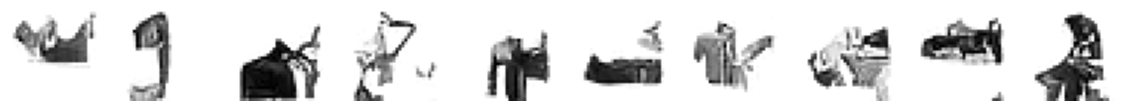

469/469 [==============================] - 243s 518ms/step - loss: 1.5033
Epoch 28/2000
469/469 [==============================] - ETA: 0s - loss: 1.5022INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_027.png


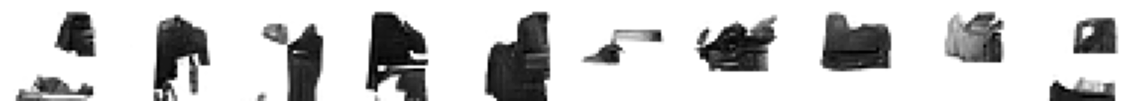

469/469 [==============================] - 243s 519ms/step - loss: 1.5022
Epoch 29/2000
469/469 [==============================] - ETA: 0s - loss: 1.5021INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_028.png


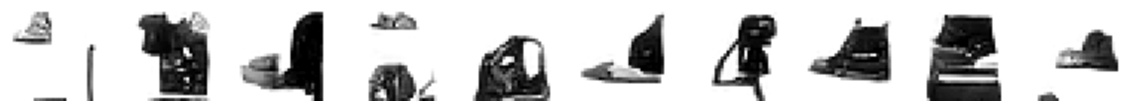

469/469 [==============================] - 243s 518ms/step - loss: 1.5021
Epoch 30/2000
469/469 [==============================] - ETA: 0s - loss: 1.4996INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_029.png


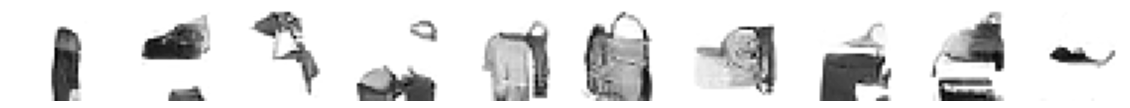

469/469 [==============================] - 243s 519ms/step - loss: 1.4996
Epoch 31/2000
469/469 [==============================] - ETA: 0s - loss: 1.4987INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_030.png


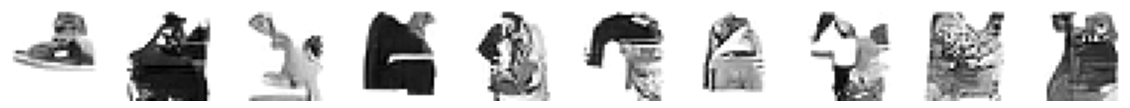

469/469 [==============================] - 243s 519ms/step - loss: 1.4987
Epoch 32/2000
469/469 [==============================] - ETA: 0s - loss: 1.4969INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_031.png


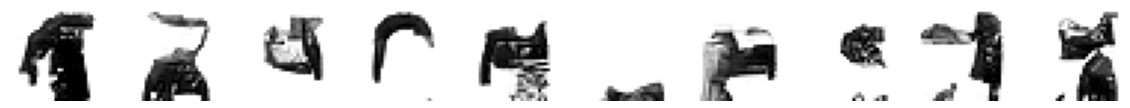

469/469 [==============================] - 243s 517ms/step - loss: 1.4969
Epoch 33/2000
469/469 [==============================] - ETA: 0s - loss: 1.4973
Saved to ./output/generated_img_032.png


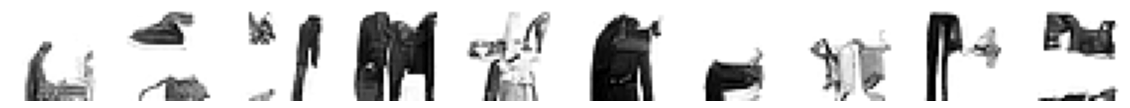

469/469 [==============================] - 241s 513ms/step - loss: 1.4973
Epoch 34/2000
469/469 [==============================] - ETA: 0s - loss: 1.4947INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_033.png


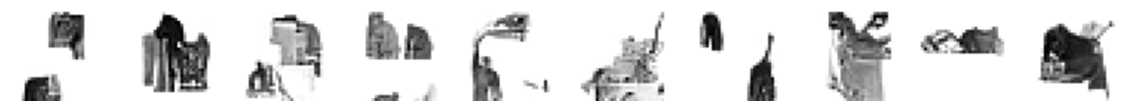

469/469 [==============================] - 243s 518ms/step - loss: 1.4947
Epoch 35/2000
469/469 [==============================] - ETA: 0s - loss: 1.4935INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_034.png


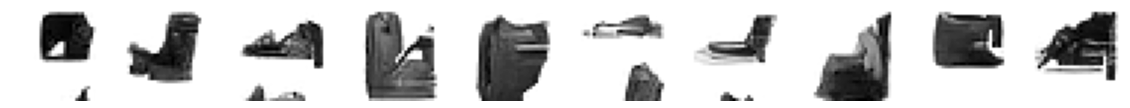

469/469 [==============================] - 243s 518ms/step - loss: 1.4935
Epoch 36/2000
469/469 [==============================] - ETA: 0s - loss: 1.4919INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_035.png


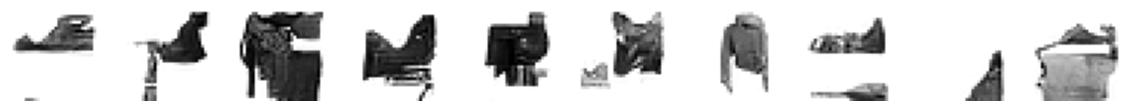

469/469 [==============================] - 243s 518ms/step - loss: 1.4919
Epoch 37/2000
469/469 [==============================] - ETA: 0s - loss: 1.4912INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_036.png


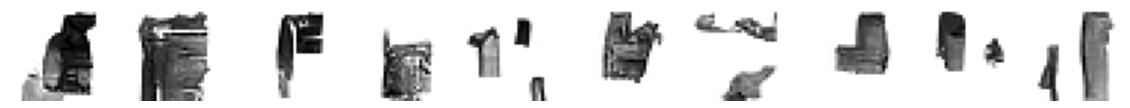

469/469 [==============================] - 243s 518ms/step - loss: 1.4912
Epoch 38/2000
469/469 [==============================] - ETA: 0s - loss: 1.4913
Saved to ./output/generated_img_037.png


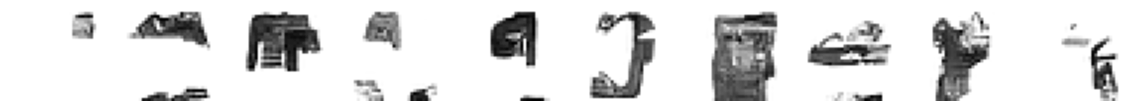

469/469 [==============================] - 241s 513ms/step - loss: 1.4913
Epoch 39/2000
469/469 [==============================] - ETA: 0s - loss: 1.4897INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_038.png


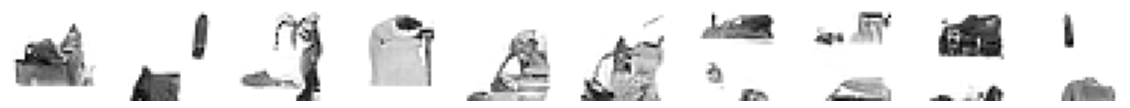

469/469 [==============================] - 243s 518ms/step - loss: 1.4897
Epoch 40/2000
469/469 [==============================] - ETA: 0s - loss: 1.4898
Saved to ./output/generated_img_039.png


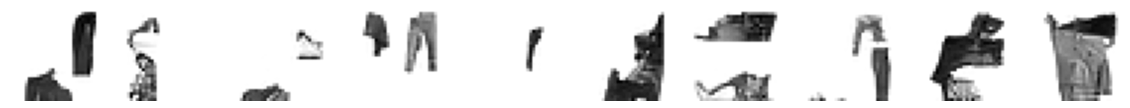

469/469 [==============================] - 240s 513ms/step - loss: 1.4898
Epoch 41/2000
469/469 [==============================] - ETA: 0s - loss: 1.4887INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_040.png


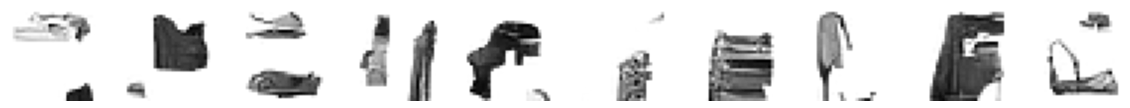

469/469 [==============================] - 243s 518ms/step - loss: 1.4887
Epoch 42/2000
469/469 [==============================] - ETA: 0s - loss: 1.4864INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_041.png


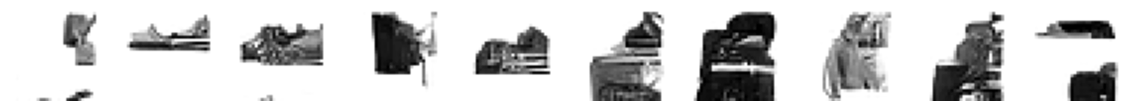

469/469 [==============================] - 243s 519ms/step - loss: 1.4864
Epoch 43/2000
469/469 [==============================] - ETA: 0s - loss: 1.4871
Saved to ./output/generated_img_042.png


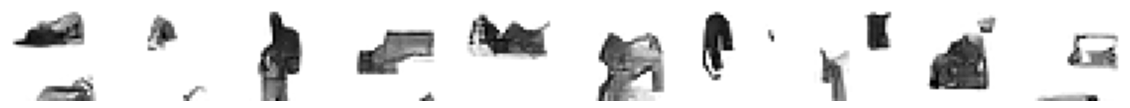

469/469 [==============================] - 241s 514ms/step - loss: 1.4871
Epoch 44/2000
469/469 [==============================] - ETA: 0s - loss: 1.4868
Saved to ./output/generated_img_043.png


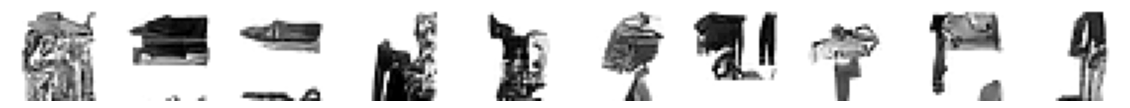

469/469 [==============================] - 244s 521ms/step - loss: 1.4868
Epoch 45/2000
469/469 [==============================] - ETA: 0s - loss: 1.4845INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_044.png


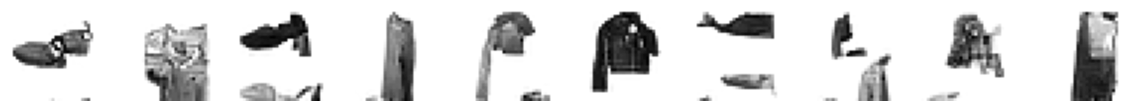

469/469 [==============================] - 248s 529ms/step - loss: 1.4845
Epoch 46/2000
469/469 [==============================] - ETA: 0s - loss: 1.4835INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_045.png


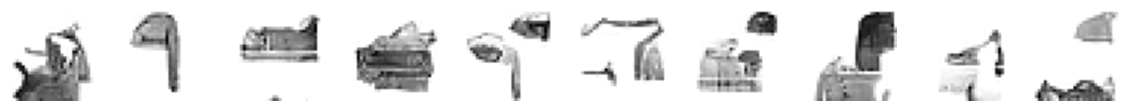

469/469 [==============================] - 247s 527ms/step - loss: 1.4835
Epoch 47/2000
469/469 [==============================] - ETA: 0s - loss: 1.4860
Saved to ./output/generated_img_046.png


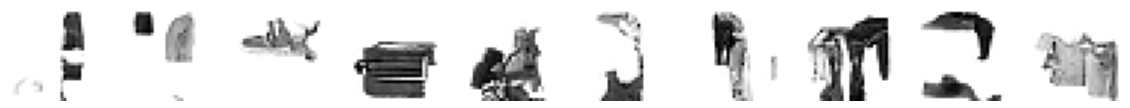

469/469 [==============================] - 242s 516ms/step - loss: 1.4860
Epoch 48/2000
469/469 [==============================] - ETA: 0s - loss: 1.4834INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_047.png


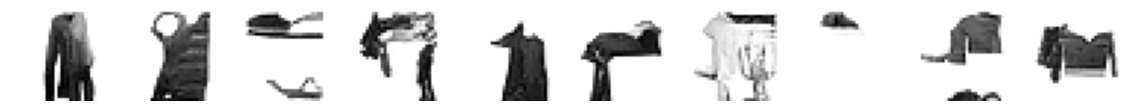

469/469 [==============================] - 245s 522ms/step - loss: 1.4834
Epoch 49/2000
469/469 [==============================] - ETA: 0s - loss: 1.4813INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_048.png


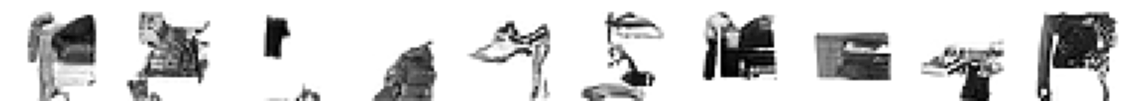

469/469 [==============================] - 243s 519ms/step - loss: 1.4813
Epoch 50/2000
469/469 [==============================] - ETA: 0s - loss: 1.4817
Saved to ./output/generated_img_049.png


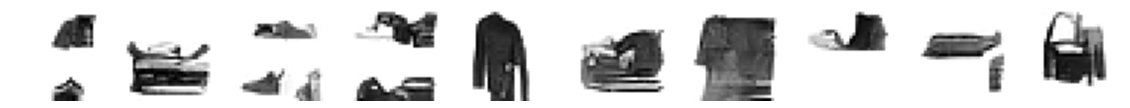

469/469 [==============================] - 241s 513ms/step - loss: 1.4817
Epoch 51/2000
469/469 [==============================] - ETA: 0s - loss: 1.4818
Saved to ./output/generated_img_050.png


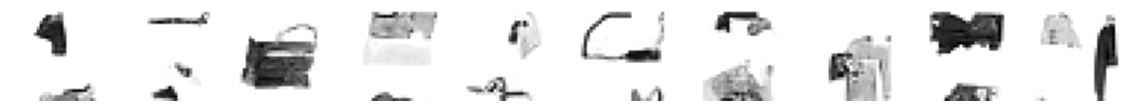

469/469 [==============================] - 241s 514ms/step - loss: 1.4818
Epoch 52/2000
469/469 [==============================] - ETA: 0s - loss: 1.4796INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_051.png


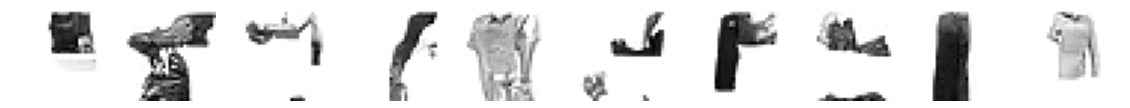

469/469 [==============================] - 243s 519ms/step - loss: 1.4796
Epoch 53/2000
469/469 [==============================] - ETA: 0s - loss: 1.4793INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_052.png


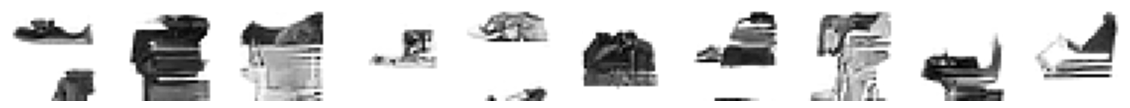

469/469 [==============================] - 244s 520ms/step - loss: 1.4793
Epoch 54/2000
469/469 [==============================] - ETA: 0s - loss: 1.4793INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_053.png


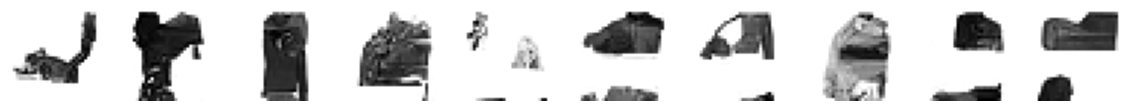

469/469 [==============================] - 243s 519ms/step - loss: 1.4793
Epoch 55/2000
469/469 [==============================] - ETA: 0s - loss: 1.4790INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_054.png


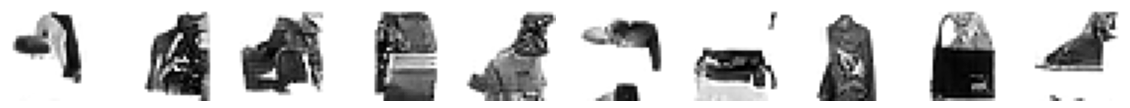

469/469 [==============================] - 243s 519ms/step - loss: 1.4790
Epoch 56/2000
469/469 [==============================] - ETA: 0s - loss: 1.4786INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_055.png


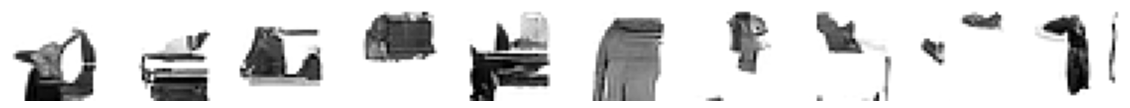

469/469 [==============================] - 243s 518ms/step - loss: 1.4786
Epoch 57/2000
469/469 [==============================] - ETA: 0s - loss: 1.4758INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_056.png


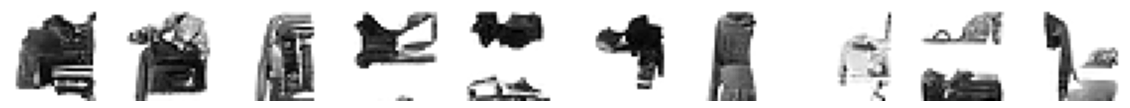

469/469 [==============================] - 244s 520ms/step - loss: 1.4758
Epoch 58/2000
469/469 [==============================] - ETA: 0s - loss: 1.4766
Saved to ./output/generated_img_057.png


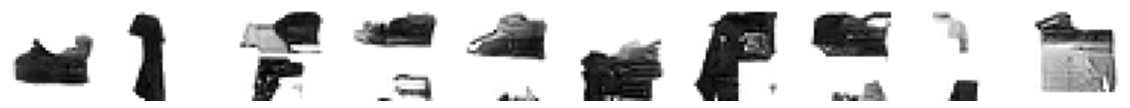

469/469 [==============================] - 240s 513ms/step - loss: 1.4766
Epoch 59/2000
469/469 [==============================] - ETA: 0s - loss: 1.4773
Saved to ./output/generated_img_058.png


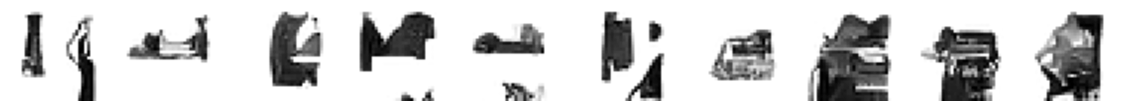

469/469 [==============================] - 240s 511ms/step - loss: 1.4773
Epoch 60/2000
469/469 [==============================] - ETA: 0s - loss: 1.4756INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_059.png


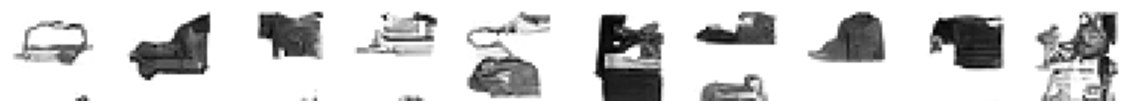

469/469 [==============================] - 242s 517ms/step - loss: 1.4756
Epoch 61/2000
469/469 [==============================] - ETA: 0s - loss: 1.4743INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_060.png


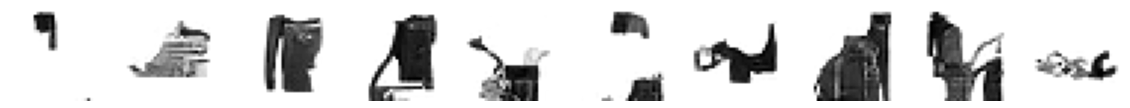

469/469 [==============================] - 243s 518ms/step - loss: 1.4743
Epoch 62/2000
469/469 [==============================] - ETA: 0s - loss: 1.4738INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_061.png


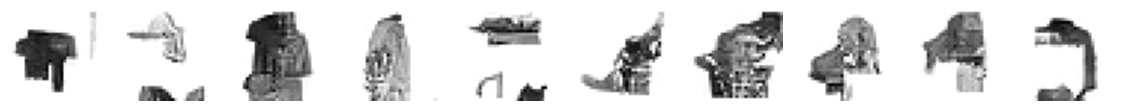

469/469 [==============================] - 243s 518ms/step - loss: 1.4738
Epoch 63/2000
469/469 [==============================] - ETA: 0s - loss: 1.4758
Saved to ./output/generated_img_062.png


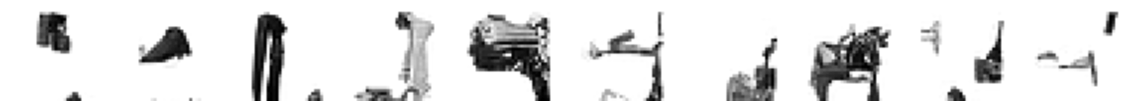

469/469 [==============================] - 240s 512ms/step - loss: 1.4758
Epoch 64/2000
469/469 [==============================] - ETA: 0s - loss: 1.4730INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_063.png


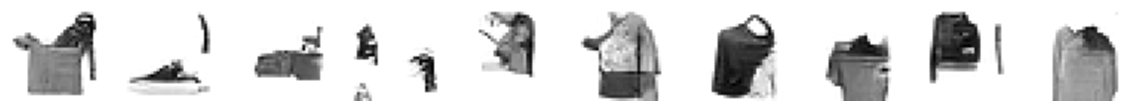

469/469 [==============================] - 243s 519ms/step - loss: 1.4730
Epoch 65/2000
469/469 [==============================] - ETA: 0s - loss: 1.4743
Saved to ./output/generated_img_064.png


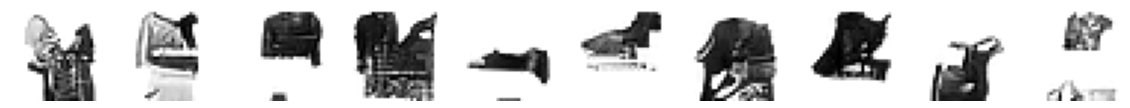

469/469 [==============================] - 240s 512ms/step - loss: 1.4743
Epoch 66/2000
469/469 [==============================] - ETA: 0s - loss: 1.4723INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_065.png


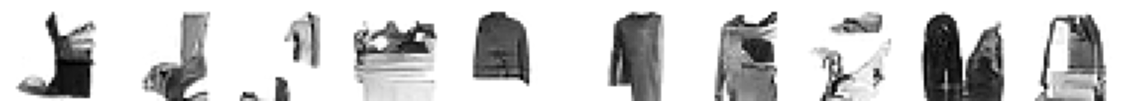

469/469 [==============================] - 243s 518ms/step - loss: 1.4723
Epoch 67/2000
469/469 [==============================] - ETA: 0s - loss: 1.4724
Saved to ./output/generated_img_066.png


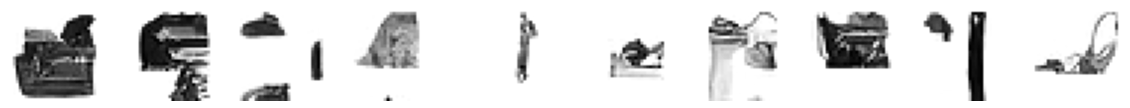

469/469 [==============================] - 240s 512ms/step - loss: 1.4724
Epoch 68/2000
469/469 [==============================] - ETA: 0s - loss: 1.4704INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_067.png


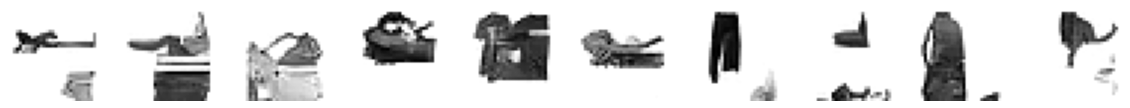

469/469 [==============================] - 242s 517ms/step - loss: 1.4704
Epoch 69/2000
469/469 [==============================] - ETA: 0s - loss: 1.4722
Saved to ./output/generated_img_068.png


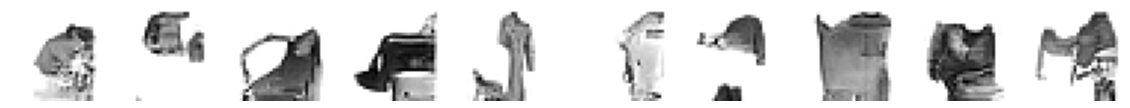

469/469 [==============================] - 240s 512ms/step - loss: 1.4722
Epoch 70/2000
469/469 [==============================] - ETA: 0s - loss: 1.4711
Saved to ./output/generated_img_069.png


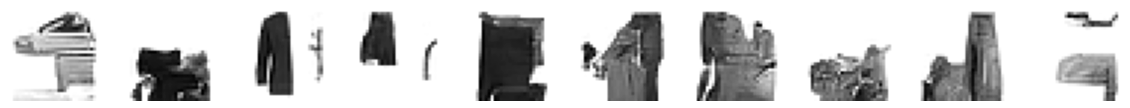

469/469 [==============================] - 240s 513ms/step - loss: 1.4711
Epoch 71/2000
469/469 [==============================] - ETA: 0s - loss: 1.4709
Saved to ./output/generated_img_070.png


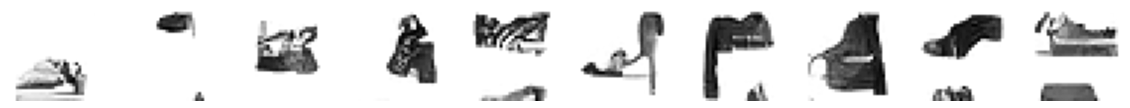

469/469 [==============================] - 241s 514ms/step - loss: 1.4709
Epoch 72/2000
469/469 [==============================] - ETA: 0s - loss: 1.4690INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_071.png


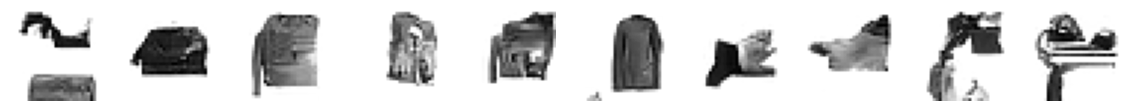

469/469 [==============================] - 243s 518ms/step - loss: 1.4690
Epoch 73/2000
469/469 [==============================] - ETA: 0s - loss: 1.4726
Saved to ./output/generated_img_072.png


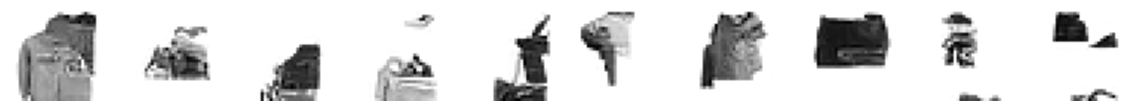

469/469 [==============================] - 241s 513ms/step - loss: 1.4726
Epoch 74/2000
469/469 [==============================] - ETA: 0s - loss: 1.4685INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_073.png


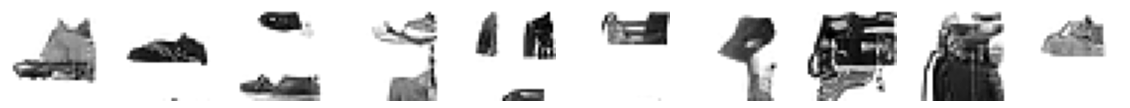

469/469 [==============================] - 243s 518ms/step - loss: 1.4685
Epoch 75/2000
469/469 [==============================] - ETA: 0s - loss: 1.4680INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_074.png


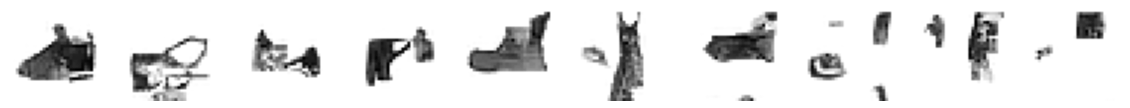

469/469 [==============================] - 243s 518ms/step - loss: 1.4680
Epoch 76/2000
469/469 [==============================] - ETA: 0s - loss: 1.4692
Saved to ./output/generated_img_075.png


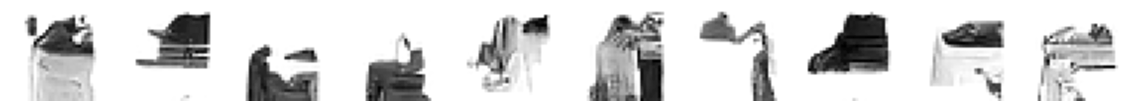

469/469 [==============================] - 240s 513ms/step - loss: 1.4692
Epoch 77/2000
469/469 [==============================] - ETA: 0s - loss: 1.4687
Saved to ./output/generated_img_076.png


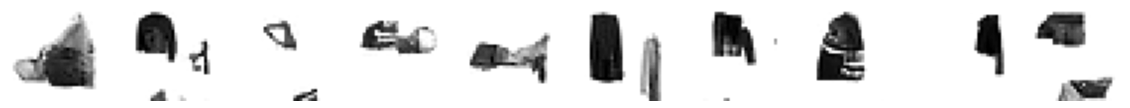

469/469 [==============================] - 240s 512ms/step - loss: 1.4687
Epoch 78/2000
469/469 [==============================] - ETA: 0s - loss: 1.4682
Saved to ./output/generated_img_077.png


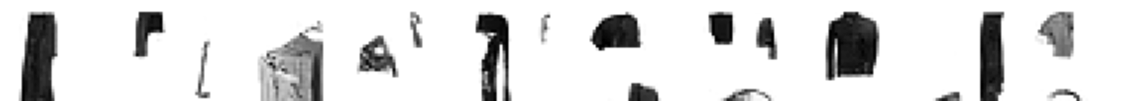

469/469 [==============================] - 240s 513ms/step - loss: 1.4682
Epoch 79/2000
469/469 [==============================] - ETA: 0s - loss: 1.4675INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_078.png


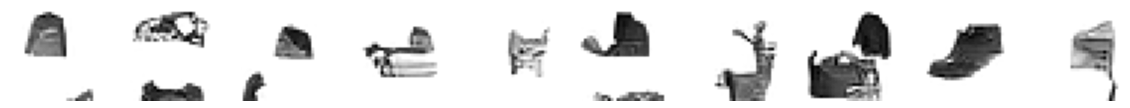

469/469 [==============================] - 243s 518ms/step - loss: 1.4675
Epoch 80/2000
469/469 [==============================] - ETA: 0s - loss: 1.4665INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets



Saved to ./output/generated_img_079.png


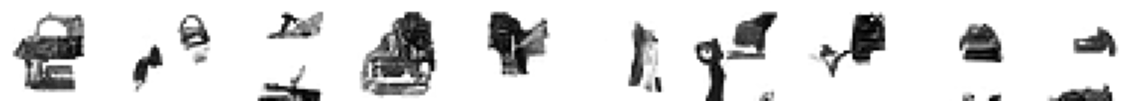

469/469 [==============================] - 243s 518ms/step - loss: 1.4665
Epoch 81/2000
422/469 [=========================>....] - ETA: 18s - loss: 1.4681

In [ ]:
pixel_cnn.fit(
    x_train
    , y_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    # , initial_epoch = 9 
    # , steps_per_epoch = 5
    , callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10)]
)

In [ ]:
# Save the final models
pixel_cnn.save("./models/pixel_cnn")

## 4. Generate images